### Apply to Real Data

## Import 

### Official Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
import os

from scipy.signal import resample, hilbert, correlate
from tqdm import tqdm
from obspy import UTCDateTime


### Own Processing Methods

In [3]:
from EchoPerformance import __echo_performance
from CreateSyntheticEventV2 import __create_synthetic_event_v2
from MakeplotDemodulationQuality import __makeplot_demodulation_quality
from MinimizeResidual import __minimize_residual
from CreateLinearChirp import __create_linear_chirp
from Tapering import __tapering
from InstaFreqHilbert import __insta_freq_hilbert
from Normalize import __normalize
from WriteToMseed import __write_to_mseed
from LoadMseed import __load_mseed
from Modulation import __modulation
from QuerrySeismoData import __querry_seismo_data


In [4]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [5]:
def third_order_derive(x, pos="MIDDLE"):

    coeff = np.zeros((5, 5))
    norm = np.array([0, 0])
    sum = 0.

    norm[0] = 12.;
    norm[1] = 84.;

    coeff[0][0] = -125
    coeff[0][1] = 136
    coeff[0][2] = 48
    coeff[0][3] = -88
    coeff[0][4] = 29
    coeff[1][0] = -38
    coeff[1][1] = -2
    coeff[1][2] = 24
    coeff[1][3] = 26
    coeff[1][4] = -10
    coeff[2][0] = 1
    coeff[2][1] = -8
    coeff[2][2] = 0
    coeff[2][3] = 8
    coeff[2][4] = -1
    coeff[3][0] = 10
    coeff[3][1] = -26
    coeff[3][2] = -24
    coeff[3][3] = 2
    coeff[3][4] = 38
    coeff[4][0] = -29
    coeff[4][1] = 88
    coeff[4][2] = -48
    coeff[4][3] = -136
    coeff[4][4] = 125

    for i in range(0, 5):
        sum += coeff[pos][i]*x[i];

    if pos == 'MIDDLE':
        sum /= norm[0];

    else:
        sum /= norm[1];

    return sum

### Own Plotting Methods

In [6]:
from MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum
from MakeplotTraceAndPSD import __makeplot_trace_and_psd
from MakeplotModulatedSignal import __makeplot_modulated_signal

## Configurations

In [7]:

oversampling = 1

# T = 1600

sps = 5000

sgnc = 302

f_lower, f_upper = 0.001, 0.05 # 0.05

# modulation_index = 1.0

# frequency_deviation = 0.5
# modulation_index = frequency_deviation/f_upper

# modulation_scheme = 3


# taper_type = "window"
# taper_percent = 0.2


# syn_signal = 'real_trace'  ## 'chirp' or 'synthetic_trace' or 'real_trace'

path_to_figs = data_path+"SagnacProcessing/figures/"

## Load Real Data

In [132]:
from obspy import read
st = read(root_path+"/Downloads/mseed/30min/DROMY_FJU_2023-09-19.mseed")

for tr in st:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

st = st.detrend("linear")
st = st.taper(0.01)
st = st.filter("bandpass", freqmin=sgnc-50, freqmax=sgnc+50, corners=4, zerophase=True)
# st = st.resample(10_000, no_filter=True)

sps = st[0].stats.sampling_rate

real_trace = st[0].data
real_times = st[0].times()

del st

## Load Demodulated Data

In [133]:
stx =  read(root_path+"/Downloads/mseed/30min/ROMY_BJU_2023-09-19.mseed")

stx = stx.detrend("linear")

model_trace = stx[0].data
model_times = stx[0].times()


-303.05 0.02519893123594153


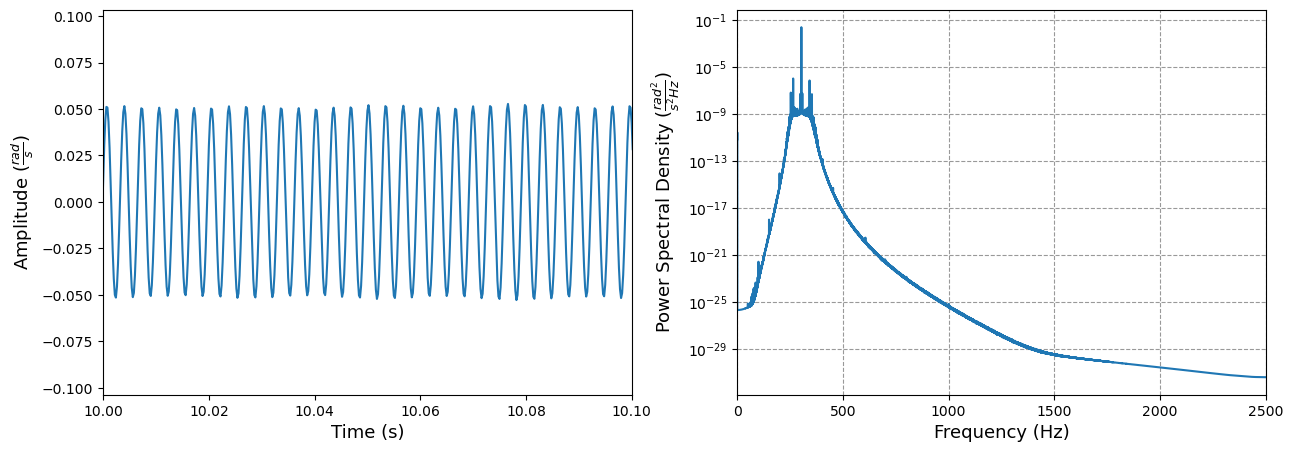

In [134]:
__makeplot_trace_and_psd(real_trace, real_times, fmax=0.5*sps, t1=10, t2=10.1);

0.0 1050167948.5898368


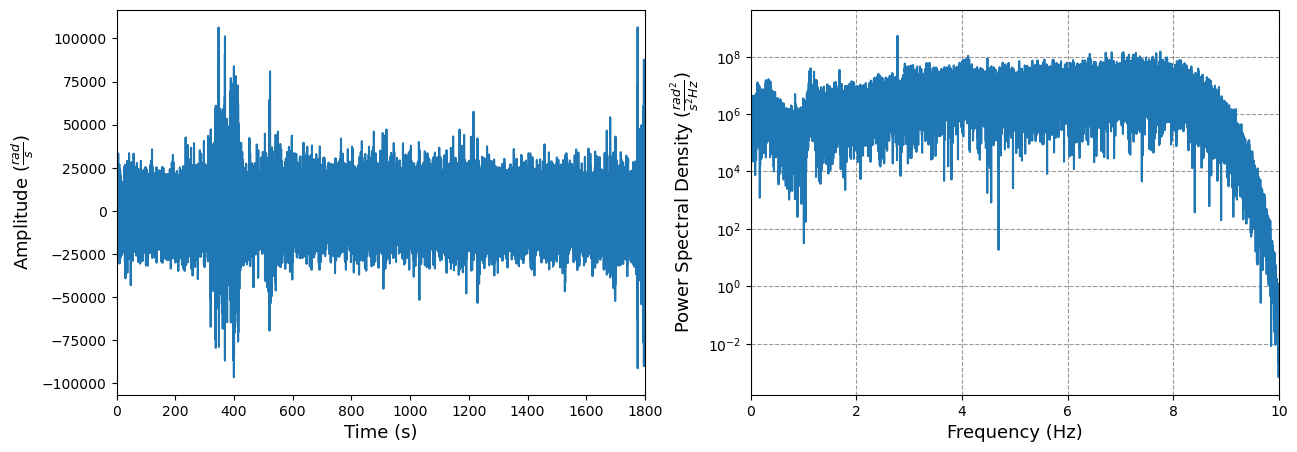

In [135]:
__makeplot_trace_and_psd(model_trace, model_times, fmax=0.5*20, t1=0, t2=30*60);

In [136]:
gc.collect()

29884

# Demodulation

In order to evaluate the demodulated signal it is compared to the kown synthetic signalthe. For this, the median is substracted and 1% of the edges are cut off. Then both, the orignal and the retrieved signal are normalized and a cross-correlation calculated.

In [137]:

# time_demod_signal, demod_signal = __insta_freq_hilbert(real_trace, real_times, sps, sgnc)


In [138]:
def __hibert_filter(sig_in, time_in, fs):

    '''
    estimating the instantaneous frequency by using the formula of Jo

    sig_in    = input signal
    time_in   = input timeline
    fs        = sampling frequency of digital signal
    '''

#     ## calulcate hilbert transform
#     hil0 = hilbert(sig_in)

#     ## extract imaginary part of hilbert transform
#     hil = np.imag(hil0)

#     ## calculate derivatives
#     d_hil = np.gradient(hil, edge_order=1)
#     d_sig = np.gradient(sig_in, edge_order=1)

#     delta_f_full = (sig_in * d_hil - d_sig * hil) / (2*np.pi*np.sqrt(sig_in**2 + hil**2))

#     del hil0, hil, d_hil, d_sig

#     ## extract real part
#     delta_f = np.real(delta_f_full)


    ## estimate instantaneous frequency with hilbert
    signal = sig_in

    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs)

    delta_f = instantaneous_frequency

    ## instert nan value for time zero (exluded bevause of np.diff() )
    sum0, idx = 0, []
    for k, x in enumerate(delta_f):
        if np.isnan(x):
            sum0 += 1
            idx.append(k)
    print(sum0, " nan found")

    for l in idx:
        delta_f[l] = 0

    return time_in, delta_f

In [139]:
def __hibert_filter2(sig_in, time_in, df, cut=10, df_out=20):

    '''
    estimating the instantaneous frequency by using the formula of Jo

    sig_in    = input signal
    time_in   = input timeline
    fs        = sampling frequency of digital signal
    '''

    import numpy as np
    from scipy.signal import decimate, detrend, hilbert
    from obspy import Stream, Trace

    ## estimate instantaneous frequency with hilbert
    analytic_signal = hilbert(sig_in)
    amplitude_envelope = np.abs(analytic_signal)
    insta_phase = np.unwrap(np.angle(analytic_signal))
    insta_frequency = np.diff(insta_phase) / (2.0*np.pi) * df
    insta_frequency = np.gradient(insta_phase) / (2.0*np.pi) * df


    # downsample data
    # insta_frequency = decimate(insta_frequency, 2, n=8, ftype='fir', zero_phase=True) # 10000 -> 5000
    # insta_frequency = decimate(insta_frequency, 5, n=8, ftype='fir', zero_phase=True) # 1000 -> 200
    # if df_out == 100 or df_out == 20:
    #     insta_frequency = decimate(insta_frequency, 2, n=8, ftype='fir', zero_phase=True) # 200 -> 100
    # if df_out == 20:
    #     insta_frequency = decimate(insta_frequency, 5, n=8, ftype='fir', zero_phase=True) # 100 -> 20

    # downsample data

    ttr = Trace()
    ttr.data = insta_frequency
    ttr.stats.sampling_rate = df
    # ttr.stats.starttime = st[0].stats.starttime

    stt = Stream(ttr)

    # stt.decimate(2) # 10000 -> 5000
    stt.decimate(5) # 5000 -> 1000
    stt.decimate(5) # 1000 -> 200
    if df_out == 100 or df_out == 20:
        stt.decimate(2) # 200 -> 100
    if df_out == 20:
        stt.decimate(5) # 100 -> 20

    insta_frequency, time_in = stt[0].data, stt[0].times()

    ## cut corrupt start and end
    nn = int(cut*df_out)
    insta_frequency = insta_frequency[nn:-nn]
    time_in = time_in[nn:-nn]

    # remove trend
    insta_frequency = detrend(insta_frequency, type='constant', bp=0)

    return time_in, insta_frequency

In [140]:

time_demod_signal, demod_signal = __hibert_filter2(real_trace, real_times, sps, cut=10, df_out=20)

gc.collect()


0

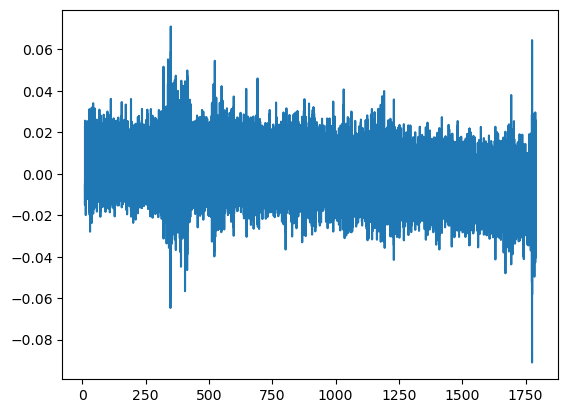

In [141]:
plt.plot(time_demod_signal, demod_signal)

In [129]:
nn = int(10*20)
model_trace_cut = model_trace[nn:-nn]

In [130]:
demod_signal_norm = demod_signal/max(abs(demod_signal))

model_trace_norm = model_trace_cut/max(abs(model_trace_cut))

ValueError: operands could not be broadcast together with shapes (35601,) (35600,) 

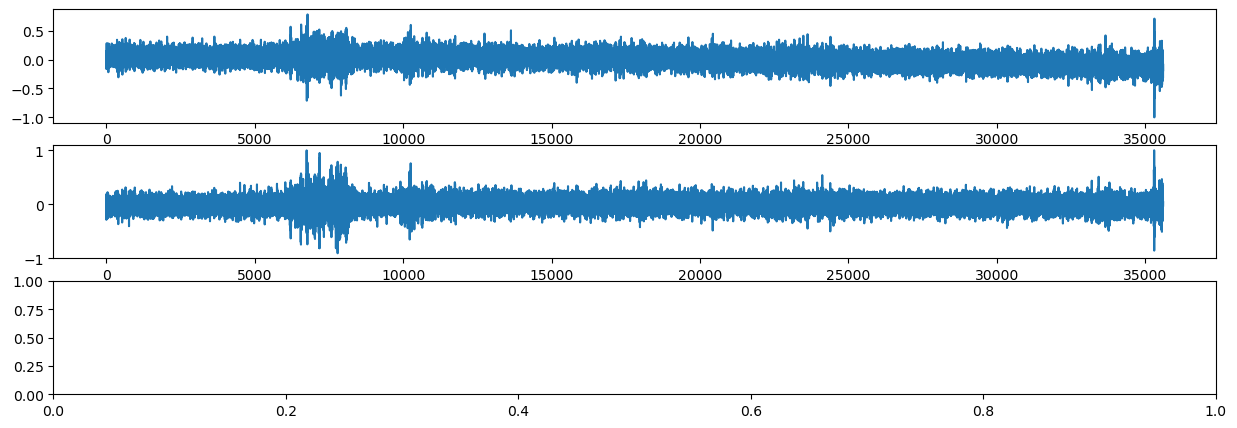

In [131]:
fig, ax = plt.subplots(3, 1, figsize=(15, 5))

ax[0].plot(demod_signal_norm)
ax[1].plot(model_trace_norm)
ax[2].plot(demod_signal_norm-model_trace_norm[1:])


In [68]:
import obspy as obs

ttr = obs.Trace()

ttr.data = demod_signal
ttr.stats.sampling_rate = 20

stt = obs.Stream(ttr)


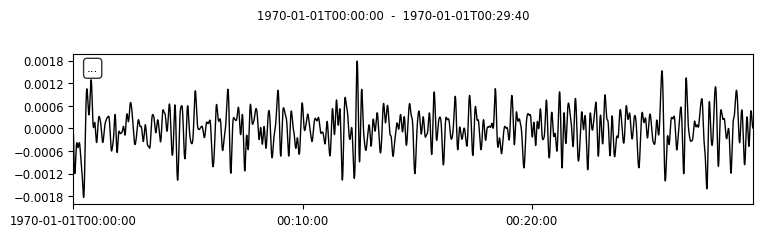

In [69]:
t1 = obs.UTCDateTime("1970-01-01T00:00:00.000000Z")
t2 = obs.UTCDateTime("1970-01-01T00:30:00.000000Z")

stt.detrend("linear")
stt = stt.filter("bandpass", freqmin=0.01, freqmax=0.1, corners=4, zerophase=True)

stt.plot();

demod_signal = stt[0].data

In [70]:
time_demod_signal, demod_signal = stt[0].times(), stt[0].data[:-1]

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 100000 is greater than input length  = 35600, using nperseg = 35600
  warnings.warn('nperseg = {0:d} is greater than input length '


-0.029213483146067417 4.772532179405571e-06


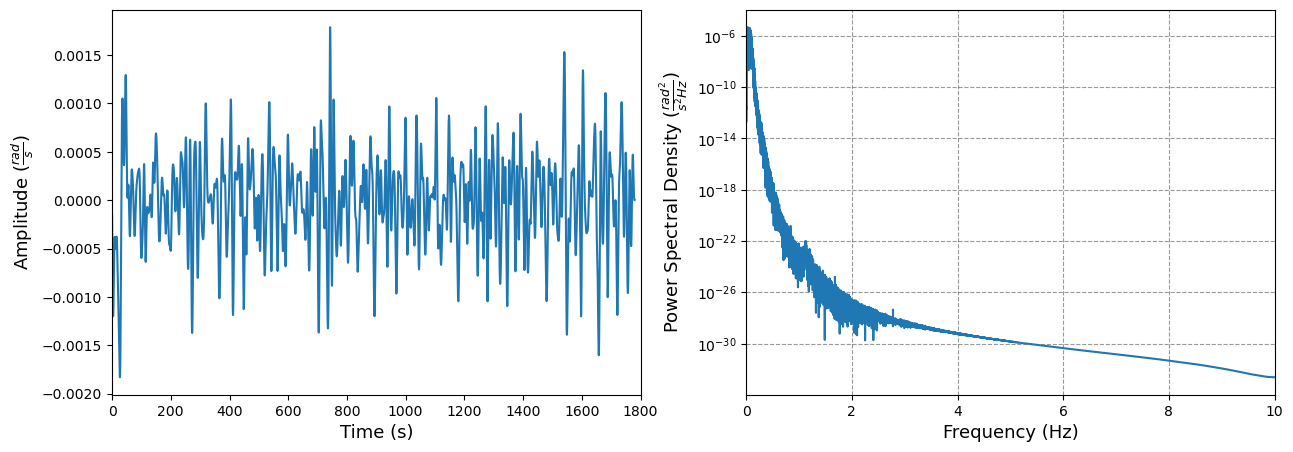

In [71]:
__makeplot_trace_and_psd(demod_signal, time_demod_signal[:-1], fmax=10, t1=0, t2=30*60);

### Remove Offset

In [ ]:
print(f"theo. Sagnac Frequencs: {sgnc} Hz")
print(f"Median Demodulated Signal: {np.median(demod_signal)}")

# demod_signal = demod_signal - sgnc
demod_signal = demod_signal - np.median(demod_signal)

### Remove Edges

In [ ]:
cutoff = int(0.01*demod_signal.size)

cut1 = np.array([i for i in demod_signal[:cutoff]])
cut2 = np.array([i for i in demod_signal[-cutoff:]])
demod_signal[:cutoff] = 0
demod_signal[-cutoff:] = 0

### Normalize

In [ ]:
demod_signal_norm = __normalize(demod_signal)
modeltrace_norm = __normalize(model_trace)

# demod_signal_norm = __tapering(demod_signal_norm, 'flanks', percent=0.1)

### Cross-Correlation

In [ ]:
# cross_corr = correlate(demod_signal, model_trace, mode='same')

# cross_corr_lags = np.arange(-cross_corr.size//2+1,cross_corr.size//2+1,1)

### Final Plotting

In [ ]:
plt.plot(model_times, modeltrace_norm)
plt.plot(time_demod_signal, demod_signal_norm)

In [ ]:
len(demod_signal_norm), len(modeltrace_norm)

In [ ]:
def __makeplot_residual(arr1, arr2, t1, t2, pcut=0.05):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec

    def __variance_reduction(arr1, arr2):
        from numpy import var
        sig1 = var(arr1)
        sig2 = var(arr2)
        return round( (sig1 - sig2) / sig1 * 100, 2)

    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __get_residual_percent(dat1, dat2):
        imax, vmax = np.argmax(abs(dat2-dat1)), np.amax(abs(dat2-dat1))
        pmax = round(np.amax(dat2-dat1)/dat1[imax]*1e2, 2)
        return pmax

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)

    def __cut(arr, pcut):
        N = len(arr)
        nx = int(N*pcut)
        arr[:nx] = np.nan
        arr[-nx:] = np.nan
        return arr

    tscale, tunit = 1, "s"


    Ncol, Nrow = 1, 3

    font = 12

    lw = 1

    scale, unit = 1, f"Hz"

    fig = plt.figure(figsize=(15, 5))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])

    ax1.plot(t1*tscale, arr1, color="black", alpha=0.2)
    ax1.plot(t2*tscale, arr2, color="tab:red", alpha=0.2)

    arr1x = __cut(arr1, pcut)
    arr2x = __cut(arr2, pcut)

    ax1.plot(t1*tscale, arr1x, color="black", label=f"modeltrace")
    ax1.plot(t2*tscale, arr2x, color="tab:red", label=f"hilbert demodulated")

    ax2.plot(t1*tscale, ( arr1x-arr2x ), color="grey", lw=lw)

    ax1.ticklabel_format(useOffset=False)
    ax1.legend(loc=1, ncol=3)

    ax1.set_ylabel(f"$\Omega$ (rad/s)", fontsize=font)
    ax2.set_ylabel(f"residual\n(rad/s)", fontsize=font)

    for ax in [ax1]:
        ax.get_xaxis().set_visible(False)

    ax2.set_xlabel(f"Time ({tunit})", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)

    arr1xn = np.nan_to_num(arr1x, 0)
    arr2xn = np.nan_to_num(arr2x, 0)

    R = __variance_reduction(arr1xn, arr1xn - arr2xn)

    txt = f"RMSE = {__rmse(arr1xn, arr2xn)}, max = {__get_residual_percent(arr1xn, arr2xn)}%, R = {R}%"

    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    ax1.set_title(f" f = {f_lower} - {f_upper} Hz")

    # ax1.grid(ls=":", zorder=0)
    # ax2.grid(ls=":", zorder=0)

    gc.collect()

    plt.plot();
    return fig

fig = __makeplot_residual(modeltrace_norm, demod_signal_norm, model_times, time_demod_signal, 0.01)

# fig.savefig(path_to_figs+f"SP_{syn_signal}_{f_lower}_{f_upper}.png", format="png", dpi=150, bbox_inches='tight')

del fig

gc.collect()

In [ ]:

# fig = __makeplot_demodulation_quality(timeline,
#                                       modeltrace_norm,
#                                       time_demod_signal,
#                                       demod_signal_norm,
#                                       cross_corr,
#                                       cross_corr_lags,
#                                       sps,
#                                      );
